## Generating names with a character-level RNN

### Read data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(\
                  c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn'
                  and c in all_letters)

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories)
print(all_categories)

# categories: 18
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


### Creating the network

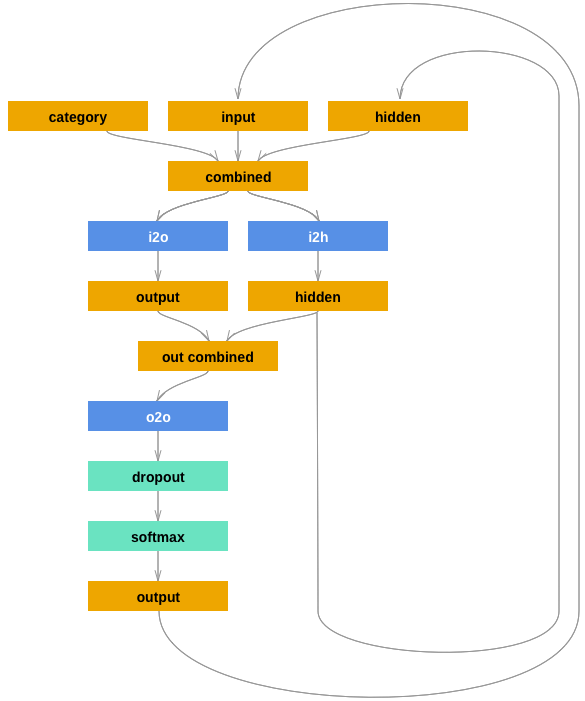

In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, _input, hidden):
        input_combined = torch.cat((category, _input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    

In [3]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [4]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indices = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indices.append(n_letters -1)
    return torch.LongTensor(letter_indices)

In [5]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### Training the network

In [6]:
criterion = nn.NLLLoss()
learning_rate = 5e-4

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
     

    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item() / input_line_tensor.size(0)
    

In [7]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds'%(m, s)

n_iters = 100000
print_every = 5000
plot_every = 500

total_loss = 0
all_losses = []

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_letters)

start = time.time()

for _iter in range(1, n_iters+1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if _iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), _iter, _iter/n_iters*100, loss))
    
    if _iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 16s (5000 5%) 3.3842
0m 41s (10000 10%) 3.0339
1m 7s (15000 15%) 2.0392
1m 34s (20000 20%) 2.4242
2m 2s (25000 25%) 2.8325
2m 30s (30000 30%) 2.7743
2m 57s (35000 35%) 1.4324
3m 25s (40000 40%) 2.2695
3m 51s (45000 45%) 2.7919
4m 15s (50000 50%) 2.3314
4m 38s (55000 55%) 2.2704
5m 2s (60000 60%) 2.2223
5m 25s (65000 65%) 2.8978
5m 48s (70000 70%) 2.5232
6m 11s (75000 75%) 2.1350
6m 34s (80000 80%) 2.9972
6m 52s (85000 85%) 2.3060
7m 7s (90000 90%) 1.6370
7m 22s (95000 95%) 2.4500
7m 37s (100000 100%) 1.6219


In [10]:
torch.save(rnn, "model/NLP_name_generator.model")

C:\Users\sjpark\Anaconda3\envs\torch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


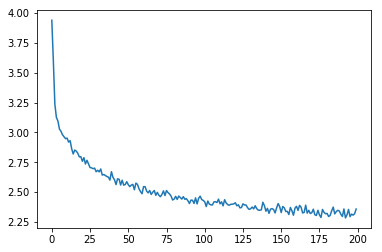

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Evaluation with confusion matrix

In [9]:
max_length = 20

def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
        
samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')


Roveki
Uanten
Shakov
Geler
Eren
Roure
Sera
Pare
Alara
Cha
Han
Iun
